# GAI Homework 4

## 1. Setup

In [1]:
import numpy as np
import torch  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.widgets import RectangleSelector
import torch.nn as nn
import torch.nn.functional as F
import cv2

import skimage
import skimage.transform

dtype = torch.cuda.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## U-Net Model

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

## Gen Training Data like DDPM do in foward process

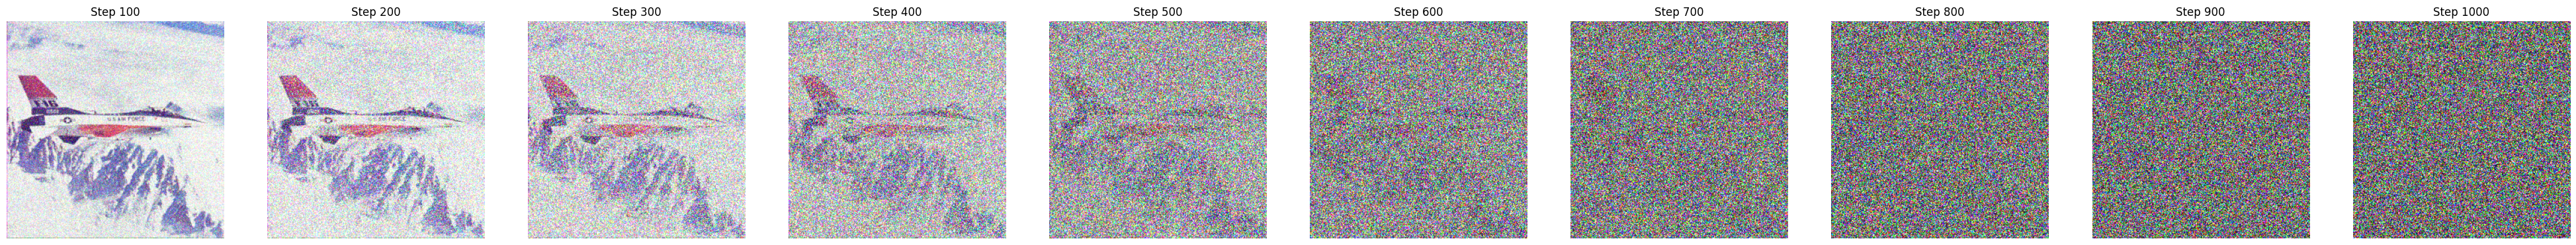

[17.310875788348, 14.964120063040454, 13.623619280825833, 11.93587967152109, 10.23250646936716, 8.926730757312608, 8.106723506193704, 7.641411691824516, 7.413500224941884, 7.302785956854505]
100


In [11]:
def show_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(50, 15))
    for idx, image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title(titles[idx])
        axes[idx].axis('off')
    plt.show()
    # plt.savefig('foo.png')
    
psnr_value_array = []

def ddpm_forward_pass(clean_image, num_steps=1000, beta_start=0.0001, beta_end=0.02):
    betas = np.linspace(beta_start, beta_end, num_steps)
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas)
    
    intermediate_images = []
    stage_images = []
    
    for t in range(num_steps):
        noise = abs(np.random.normal(0, 0.6, clean_image.shape))
        # print(noise)
        # print('---')
        # print(clean_image)
        alpha_t = alphas_cumprod[t]
        x_t = np.clip(np.sqrt(alpha_t) * clean_image +  np.sqrt(1 - alpha_t) * noise,0,1)
        
        if t%10 == 9:
            stage_images.append(x_t)

        if t %100 == 99:
            intermediate_images.append(x_t)
            psnr_value_array.append(skimage.metrics.peak_signal_noise_ratio(clean_image,x_t))
    
    return intermediate_images , stage_images


clean_image = skimage.io.imread('F16_GT.png')
clean_image = skimage.transform.resize(clean_image,(256,256))

intermediate_images,stage_images = ddpm_forward_pass(clean_image)

titles = [f"Step {i*100}" for i in range(1, 11)]

# print(intermediate_images[0])
skimage.io.imsave('synthetic_noise.png',(intermediate_images[0]*255).astype(np.uint8))

show_images(intermediate_images, titles)
print(psnr_value_array)
print(len(stage_images))

## Training

In [18]:
def train_model(model,mse, optimizer,target_image,noise_images, num_epochs=50):
    result = []
    step = 0
    
    target_image = skimage.transform.resize(target_image,(256,256))
    target_image = torch.from_numpy(target_image).to(torch.float).permute(2,0,1).unsqueeze(0).to(device)
    print('target:', target_image.shape)
    
    for i in range(1,len(noise_images)+1):
    # for i in range(1,2):
        
        # now = target_image 
        
        now = noise_images[len(noise_images)-i] / 255
        now = torch.from_numpy(now).to(torch.float).permute(2,0,1).unsqueeze(0).to(device)
        
        all_noise_input = torch.from_numpy(abs(np.random.normal(0, 0.6, now.shape))).to(torch.float).to(device)
        # all_noise_input = torch.from_numpy(np.ones(now.shape)).to(torch.float).to(device)
        # result.append(all_noise_input.squeeze(0).permute(1, 2, 0).cpu().numpy())
        
        print(all_noise_input.shape)
        
        patience = 0
        
        for epoch in range(num_epochs):
            best_psnr = 0
            
            model.train()
            if epoch % 20 == 19:
                print('Iteration {}/{}'.format(epoch, num_epochs - 1))
            epoch_loss = 0
            # inputs = now.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(all_noise_input)
            
            loss = mse(now,outputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            model.eval()
            with torch.no_grad():
                
                outputs = outputs.squeeze(0).permute(1, 2, 0).cpu().numpy() 
                target_back_to_np = target_image.squeeze(0).permute(1, 2, 0).cpu().numpy() 
                
                psnr = skimage.metrics.peak_signal_noise_ratio(outputs,target_back_to_np)
                
                if best_psnr <= psnr:
                    best_psnr = psnr
                else :
                    patience+=1
                if patience >= 5:
                    break;
                    
                # if epoch == num_epochs - 1 or (i == 1 and epoch == 0):
                if i % 10 == 1 and epoch == num_epochs - 1 :
                    
                    # outputs = (outputs.cpu().numpy() * 255 ).astype(np.uint8)
                    # Convert the reshaped tensor to a NumPy array
                    result.append(outputs)
                    print('save image of stage ',i)
                    
        # torch.save(model.state_dict(), 'weights_%d.pth' % epoch )
        print(f'Pass to stage {i}')
    
    return model,result

def train(target_image,stage_images):

    target_image = skimage.transform.resize(target_image,(256,256))
    # intermediate_images,sample_images = ddpm_forward_pass(target_image)
    model = Unet(3, 3).to(device)
    mse = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model,result = train_model(model,mse, optimizer, target_image,stage_images)
    titles = [f"Step {i}" for i in range(len(result)+1)]
    show_images(result,titles)
    
    return result

image = skimage.io.imread('synthetic_noise.png')
sus = train(image,stage_images=stage_images)

target: torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


ValueError: image_true has intensity values outside the range expected for its data type. Please manually specify the data_range.

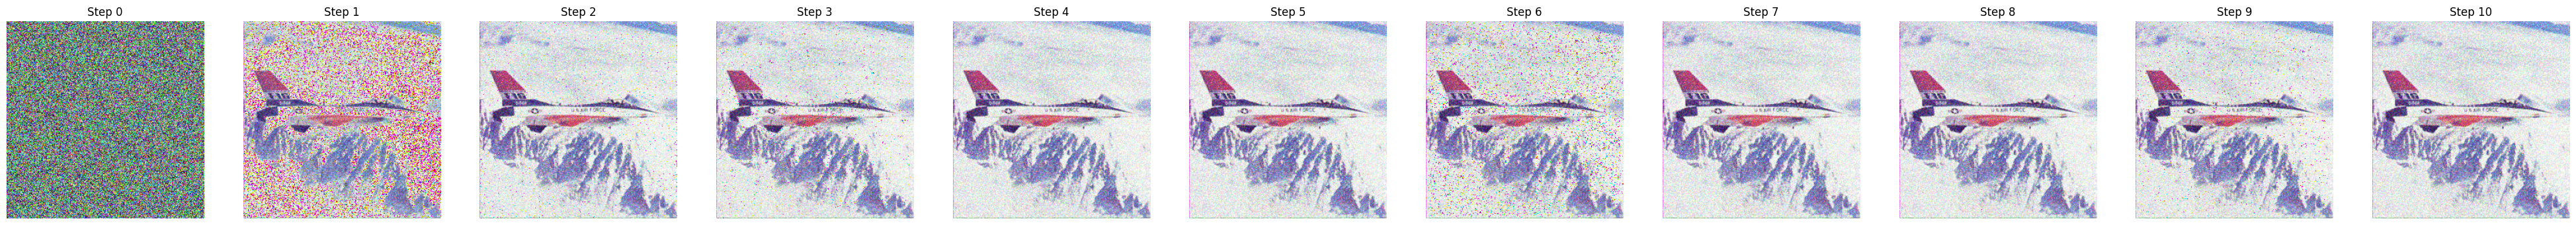

In [47]:
Titile = [f"Step {i}" for i in range(len(sus)+1)]
show_images(sus,Titile)